In [10]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.transforms.functional as TF
from text3d2video.artifacts.animation_artifact import AnimationArtifact

torch.set_grad_enabled(False)

anim_artifact = 'rumba:latest'
anim_artifact = 'backflip:latest'
anim_artifact = 'human_rotation_90:latest'
anim_artifact = 'cat_rotation_90:latest'

# read animation
animation = AnimationArtifact.from_wandb_artifact_tag(anim_artifact)
uv_verts, uv_faces = animation.texture_data()

n_frames = 5
cams, mesh_frames = animation.cams_and_frames(n_frames)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  warnings.warn(f"Mtl file does not exist: {f}")

  cameras = torch.load(self._cameras_path())



KeyboardInterrupt: 

In [ ]:
import torch
from diffusers.models import ControlNetModel
from diffusers.schedulers import DPMSolverMultistepScheduler

from text3d2video.generative_rendering.generative_rendering_pipeline import (
    GenerativeRenderingPipeline,
)

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: GenerativeRenderingPipeline = GenerativeRenderingPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from text3d2video.artifacts.gr_data import GrSaveConfig
from text3d2video.generative_rendering.configs import GenerativeRenderingConfig, NoiseInitializationConfig, NoiseInitializationMethod
from text3d2video.ipython_utils import display_ims

module_paths = [
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    seed=0,
    resolution=512,
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=0.8,
    attend_to_self_kv=False,
    mean_features_weight=0.5,
    chunk_size=5,
    num_keyframes=4,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

gr_save_cfg = GrSaveConfig(
    enabled=False,
    n_frames=-1,
    n_timesteps=5,
    save_latents=True,
    save_q=True,
    save_k=True,
    save_v=True,
    out_artifact="gr_data",
    module_paths=module_paths,
    save_kf_post_attn=True,
    save_aggregated_features=True
)


noise_config = NoiseInitializationConfig(
    method=NoiseInitializationMethod.UV,
)
noise_config.uv_texture_res = 64

prompt = "Deadpool"

video_frames = pipe(
    prompt,
    mesh_frames,
    cams,
    uv_verts,
    uv_faces,
    generative_rendering_config=gr_config,
    noise_initialization_config=noise_config,
    gr_save_config=gr_save_cfg,
)

art = pipe.gr_data_artifact
print(art.folder)

display_ims(video_frames)

 10%|█         | 1/10 [00:01<00:10,  1.20s/it]

In [ ]:
import os
print(art.folder, os.system(f'du -h {art.folder}'))

frame_indices = art.diffusion_data.save_frame_indices
time_steps = art.diffusion_data.save_step_times
modules = art.diffusion_data.save_module_paths

8,0K	/tmp/tmp_2dukvrw
/tmp/tmp_2dukvrw 0


In [ ]:
from text3d2video.sd_feature_extraction import read_layer_paths

enc_layers, mid_layers, dec_layers = read_layer_paths(modules)

In [ ]:
from text3d2video.video_util import pil_frames_to_clip
from PIL import Image

def latents_video(latents):
    frames = []
    for latent in latents:
        frame = TF.to_pil_image(latent[0:3].cpu())
        frame = frame.resize((512, 512), Image.NEAREST)
        frames.append(frame)
    return frames


frame_latents = art.read_latents_at_timestep(time_steps[0])
vid = latents_video(frame_latents)
clip = pil_frames_to_clip(vid)
clip.ipython_display(width=512)

KeyError: 'Unable to synchronously open object (component not found)'

In [ ]:
frame = frame_indices[0]
time = time_steps[-1]
attn_layer = dec_layers[-1]
module_path = attn_layer.module_path()

# read key/qry/val
qry = art.attn_writer.read_qry(time, frame, module_path)
key = art.attn_writer.read_key(time, frame, module_path)
val = art.attn_writer.read_val(time, frame, module_path)

kf_indices = art.gr_writer.read_kf_indices(time)

In [ ]:
from text3d2video.attention_visualization import split_heads

# get head key/qry/val
head_idx = 2
qry_mh = split_heads(qry.unsqueeze(0))
key_mh = split_heads(key.unsqueeze(0))
val_mh = split_heads(val.unsqueeze(0))
qry_head = qry_mh[0, :, head_idx, :]
key_head = key_mh[0, :, head_idx, :]
val_head = val_mh[0, :, head_idx, :]


(<matplotlib.image.AxesImage at 0x7580b392c2e0>,
 <matplotlib.image.AxesImage at 0x7580b392c790>)

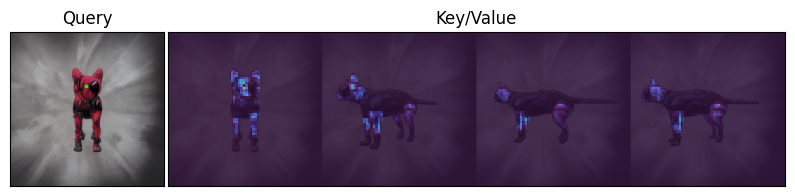

In [ ]:
from torch import Tensor
from text3d2video.attention_visualization import add_pixel_marker, compute_attn_weights, concatenate_images, coord_to_pixel, make_gridspec_figure, pixel_coord_flattened, plot_image_and_weight, reshape_concatenated

plot_attn_weights = compute_attn_weights(qry_head.unsqueeze(0), key_head.unsqueeze(0))[0]

fig, gs = make_gridspec_figure(1, 2, width_ratios=[1, 4], height_ratios=[1], scale=2)
ax_qry = fig.add_subplot(gs[0, 0])
ax_kv = fig.add_subplot(gs[0, 1])
for ax in [ax_kv, ax_qry]:
    ax.set_xticks([])
    ax.set_yticks([])
ax_qry.set_title('Query')
ax_kv.set_title('Key/Value')

qry_coord = Tensor([0.49, 0.35])
layer_res = attn_layer.layer_resolution(pipe.unet)

qry_im = video_frames[0]
qry_grid_size = (layer_res, layer_res)

ax_qry.imshow(qry_im)
add_pixel_marker(ax_qry, qry_coord, qry_im.size, qry_grid_size)

qry_pix = coord_to_pixel(qry_coord, qry_grid_size)
qry_pix_1d = pixel_coord_flattened(qry_pix, qry_grid_size)

weights = plot_attn_weights[qry_pix_1d, :]
weights = reshape_concatenated(weights.unsqueeze(-1), layer_res=layer_res)[0]

kv_im = concatenate_images([video_frames[idx.int()] for idx in kf_indices])
plot_image_and_weight(ax_kv, kv_im, weights, interpolation='nearest')

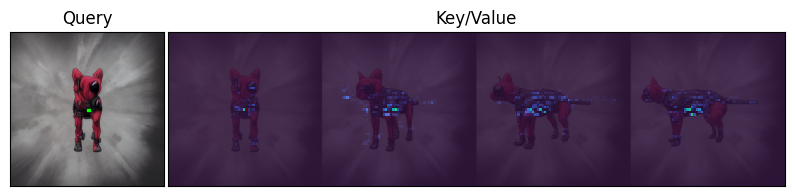

In [ ]:
from typing import List
from PIL.Image import Image


def plot_attn_weights(
    qry: Tensor,
    key: Tensor,
    qry_coord: Tensor,
    images: List[Image],
    qry_idx: int,
    kv_indices: int,
    head_index=2,
):
    layer_res = 64

    # get q/k for head
    qry_mh = split_heads(qry.unsqueeze(0))
    key_mh = split_heads(key.unsqueeze(0))
    qry_head = qry_mh[0, :, head_index, :]
    key_head = key_mh[0, :, head_index, :]

    # setup figure
    fig, gs = make_gridspec_figure(
        1, 2, width_ratios=[1, 4], height_ratios=[1], scale=2
    )
    ax_qry = fig.add_subplot(gs[0, 0])
    ax_kv = fig.add_subplot(gs[0, 1])
    for ax in [ax_kv, ax_qry]:
        ax.set_xticks([])
        ax.set_yticks([])
    ax_qry.set_title("Query")
    ax_kv.set_title("Key/Value")

    qry_im = images[qry_idx]
    qry_grid_size = (layer_res, layer_res)

    # plot query image with marker
    ax_qry.imshow(qry_im)
    add_pixel_marker(ax_qry, qry_coord, qry_im.size, qry_grid_size)

    # get query pixel coordinate
    qry_pix = coord_to_pixel(qry_coord, qry_grid_size)
    qry_pix_1d = pixel_coord_flattened(qry_pix, qry_grid_size)

    # compute attn weights
    attn_weights = compute_attn_weights(qry_head.unsqueeze(0), key_head.unsqueeze(0))[0]
    weights = attn_weights[qry_pix_1d, :]
    weights = reshape_concatenated(weights.unsqueeze(-1), layer_res=layer_res)[0]

    # get images
    kv_im = concatenate_images([images[idx] for idx in kv_indices])
    plot_image_and_weight(ax_kv, kv_im, weights, interpolation="nearest", alpha=0.8)


qry = art.attn_writer.read_qry(time, frame, module_path)
key = art.attn_writer.read_key(time, frame, module_path)

plot_attn_weights(qry, key, Tensor([0.5, 0.5]), video_frames, 0, [0, 1, 2, 3])

In [ ]:
kqry = art.attn_writer.read_qry(time, frame, module_path)
key = art.attn_writer.read_key(time, frame, module_path)

head_index = 0
qry_mh = split_heads(qry.unsqueeze(0))
key_mh = split_heads(key.unsqueeze(0))
qry_head = qry_mh[0, :, head_index, :]
key_head = key_mh[0, :, head_index, :]


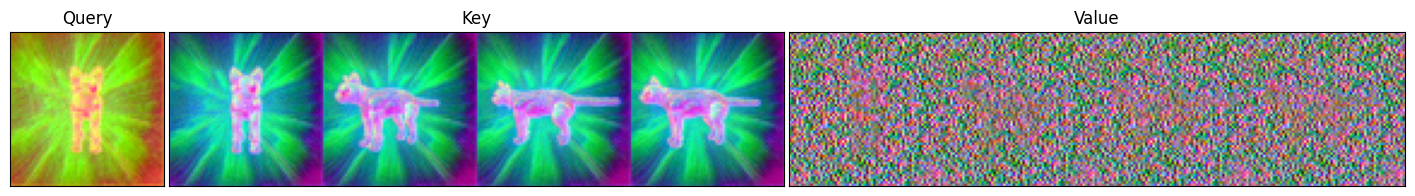

In [ ]:
from einops import rearrange

from text3d2video.attention_visualization import reshape_concatenated, split_heads
from text3d2video.feature_visualization import RgbPcaUtil, reduce_feature_map
from text3d2video.ipython_utils import display_ims, display_ims_grid

layer_res = attn_layer.layer_resolution(pipe.unet)
qry_square = rearrange(qry_head, "(h w) d -> d h w", h=layer_res)
key_square = reshape_concatenated(key_head, layer_res)
val_square = reshape_concatenated(val_head, layer_res)

qk_features = torch.cat([qry_head, key_head], dim=0)
pca_qk = RgbPcaUtil.init_from_features(qk_features)

val_rgb = reduce_feature_map(val_square)
qry_rgb = pca_qk.feature_map_to_rgb_pil(qry_square)
key_rgb = pca_qk.feature_map_to_rgb_pil(key_square)

fig, gs = make_gridspec_figure(1, 3, width_ratios=[1, 4, 4], height_ratios=[1])
ax_qry = fig.add_subplot(gs[0, 0])
ax_key = fig.add_subplot(gs[0, 1])
ax_val = fig.add_subplot(gs[0, 2])

ax_qry.imshow(qry_rgb)
ax_key.imshow(key_rgb)
ax_val.imshow(val_rgb)

ax_qry.set_title("Query")
ax_key.set_title("Key")
ax_val.set_title("Value")

for ax in [ax_qry, ax_key, ax_val]:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
time = time_steps[0]
attn_layer = dec_layers[-1]
module_path = attn_layer.module_path()

In [ ]:
vert_features = art.gr_writer.read_vertex_features(time, module_path)

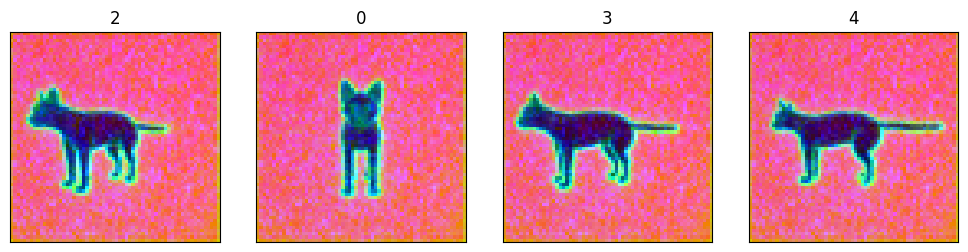

In [ ]:

kf_indices = art.gr_writer.read_kf_indices(time)
kf_features = art.gr_writer.read_kf_post_attn(time, module_path)[0]

kf_features_flat = rearrange(kf_features, "n c h w -> (n h w) c")
pca = RgbPcaUtil.init_from_features(kf_features_flat)

kf_features_pil = [pca.feature_map_to_rgb_pil(fmap) for fmap in kf_features]
display_ims_grid([kf_features_pil], col_titles=[int(i) for i in kf_indices])

In [ ]:
from torch import Tensor
from text3d2video.camera_placement import turntable_cameras
from text3d2video.rendering import make_feature_renderer
from pytorch3d.renderer import TexturesVertex
from pytorch3d.structures import Meshes

vert_ft = vert_features[0]

def view_vert_features(
    mesh: Meshes, vert_features: Tensor, pca=None, render_res=200, n_frames=25
):
    if pca is None:
        pca = RgbPcaUtil.init_from_features(vert_features)

    # dimensionality reduce
    vert_ft_rgb = pca.features_to_rgb(vert_features)
    vert_ft_rgb = Tensor(vert_ft_rgb)

    # turntable cameras
    cameras = turntable_cameras(n_frames, 2)

    # render
    renderer = make_feature_renderer(cameras, render_res, "cuda")
    render_mesh = mesh.clone()
    render_mesh = render_mesh.extend(len(cameras))
    render_mesh.textures = TexturesVertex(
        vert_ft_rgb.expand(len(cameras), -1, -1).cuda()
    )

    renders = renderer(render_mesh)
    renders_pil = [TF.to_pil_image(rearrange(r, "h w c -> c h w")) for r in renders]

    return renders_pil


unposed = animation.load_unposed_mesh()
kf_index = int(kf_indices[0])
unposed = mesh_frames[kf_index]

frames = view_vert_features(unposed, vert_ft, pca, render_res=512, n_frames=25)
pil_frames_to_clip(frames, duration=1.5).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
